In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models import DummyNet
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE

%matplotlib inline


In [31]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
checkpoint = torch.load("checkpoints/checkpoint_30.pkl", map_location=device)
model = DummyNet().to(device)
model.load_state_dict(checkpoint["model"], strict=False)


<All keys matched successfully>

In [32]:
dataset = ImageFolder(
    root="dataset/",
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((224, 224))]
    ),
)

loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
images, labels = next(iter(loader))
images.size(), labels.size()


(torch.Size([611, 3, 224, 224]), torch.Size([611]))

In [36]:
images = images.to(device)
embedded_images = model(images)
embedded_images = embedded_images.detach().cpu().numpy()
embedded_images = TSNE(
    n_components=2,
).fit_transform(embedded_images)
embedded_images.shape

/home/cdlab2022/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cdlab2022/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(611, 2)

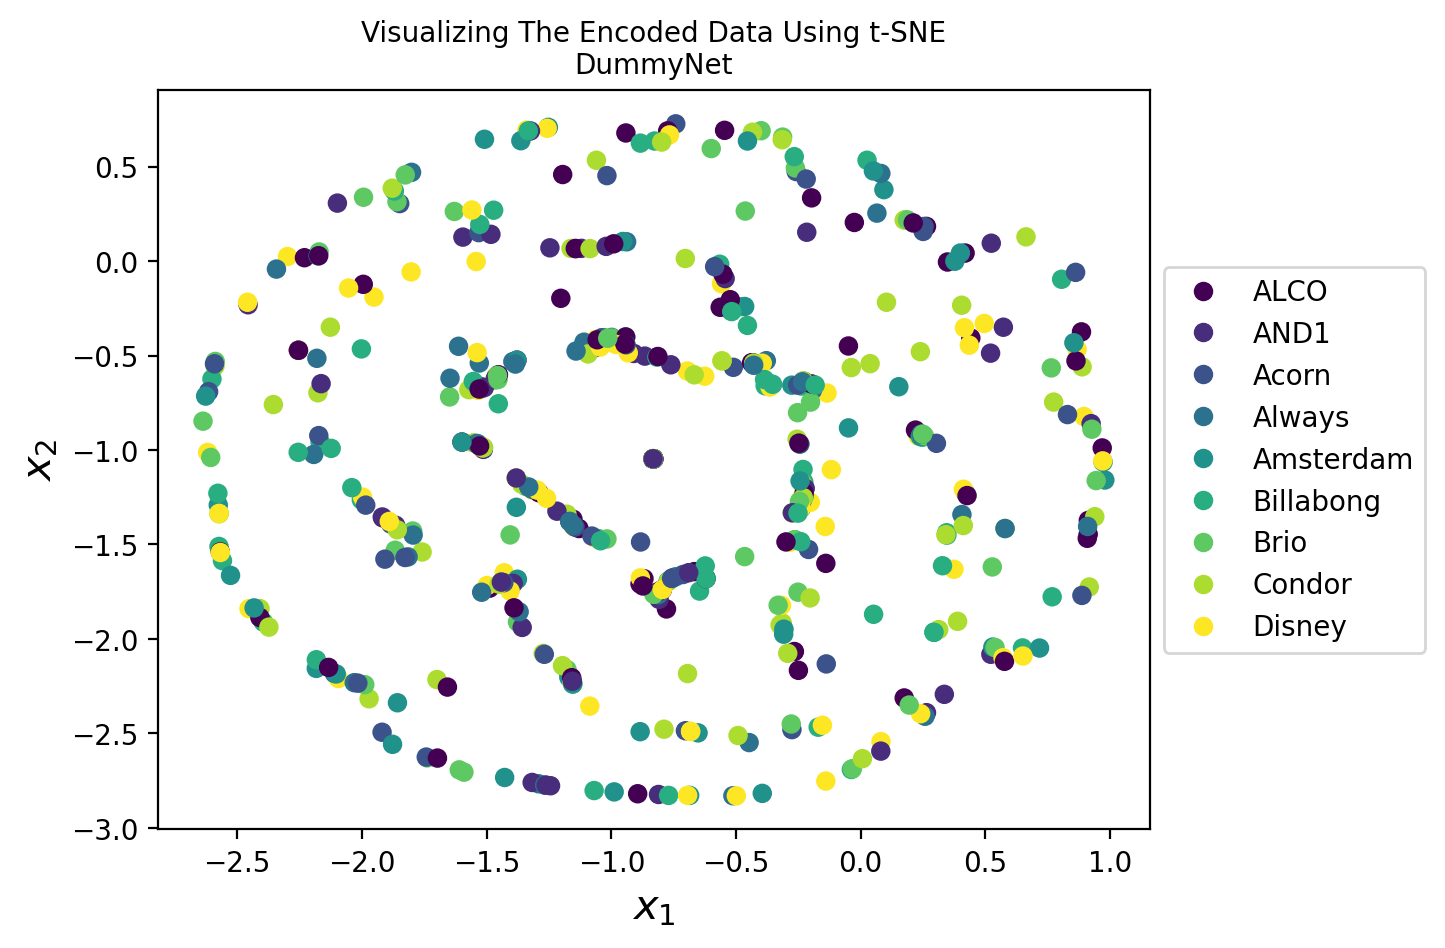

In [40]:
num_epochs = 30
plt.figure(dpi=200)
scatter = plt.scatter(embedded_images[:, 0], embedded_images[:, 1], c=labels)
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, dataset.classes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(
    "Visualizing The Encoded Data Using t-SNE\n{}".format(
        model.__class__.__name__
    ),
    fontsize=10,
)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.savefig("tsne_vis_{}_{}.jpg".format(model.__class__.__name__, num_epochs))

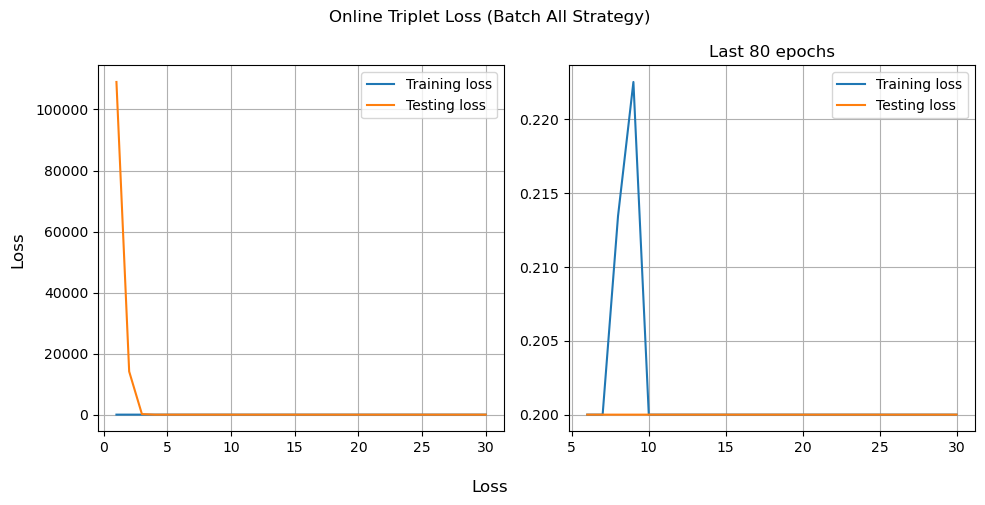

In [41]:
history = checkpoint["loss_history"]
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10,5))
# axs[0].set_title("All epochs")
axs[0].plot(list(range(1, num_epochs + 1)), history["train"], label="Training loss")
axs[0].plot(list(range(1, num_epochs + 1)), history["test"], label="Testing loss")
axs[0].grid(True)
axs[0].legend()

axs[1].set_title("Last 80 epochs")
axs[1].plot(list(range(1, num_epochs + 1))[5:], history["train"][5:], label="Training loss")
axs[1].plot(list(range(1, num_epochs + 1))[5:], history["test"][5:], label="Testing loss")
axs[1].grid(True)
axs[1].legend()

fig.suptitle("Online Triplet Loss (Batch All Strategy)")
fig.supxlabel("Loss")
fig.supylabel("Loss")
plt.tight_layout()
plt.locator_params(axis="x", integer=True, tight=True)
plt.savefig("history_{}_{}.jpg".format(model.__class__.__name__, num_epochs), dpi=300)
# plt.close()